In [1]:
import sys
from pathlib import Path

# Ubicación del notebook
NOTEBOOK_DIR = Path.cwd()

# Raíz del proyecto = subir un nivel desde Notebooks/
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Añadir raíz del proyecto al sys.path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Proyecto raíz detectado:", PROJECT_ROOT)

Proyecto raíz detectado: c:\Proyectos\EduFinance\EduFinance_Simulator


In [ ]:
"""Importamos las librerias"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.paths import DATA_DIR, FIG_DIR
from utils.loader import load_csv

print("📁 DATA_DIR:", DATA_DIR)
print("📁 FIG_DIR:", FIG_DIR)


📁 DATA_DIR: C:\Proyectos\EduFinance\EduFinance_Simulator\data
📁 FIG_DIR: C:\Proyectos\EduFinance\EduFinance_Simulator\figures


In [3]:
"""Cargamos los datos"""

market_df = load_csv("raw_market_data.csv")

In [ ]:
u"""
Sanity check: Cobertura temporal por ticker

El objetivo de este bloque es verificar que la descarga de datos
desde Yahoo Finance fue correcta para cada activo.

1. Agrupamos por 'ticker'.
2. Calculamos:
  - first_date: primera fecha disponible en la serie.
  - last_date : última fecha disponible.
  - n_rows    : cantidad total de observaciones (filas).
  - n_missing : cantidad de valores nulos en 'close'.
3. Ordenamos los resultados por ticker para facilitar la inspección.

Este chequeo es importante porque:
  - Nos ayuda a identificar si algún activo tiene un rango temporal
    mucho más corto que el resto (ej. XRP con datos recientes).
  - Detecta gaps grandes o descargas vacías.
  - Nos da un panorama rápido de la consistencia antes de pasar
  a la normalización de fechas.

"""

checks = (
    market_df
    .groupby("ticker")
    .agg(
        first_date=("date", "min"),   # primera fecha disponible
        last_date=("date", "max"),    # última fecha disponible
        n_rows=("date", "count"), # cantidad de observaciones
        n_missing = ("close", lambda s: s.isna().sum()), # nulos en 'close'
        asset_class = ("asset_class", "first"), # clase del activo
        currency = ("currency", "first")
    )
    .sort_index()
)

checks


,first_date,last_date,n_rows,n_missing,asset_class,currency
ticker,,,,,,
BTC-USD,2015-01-02,2025-09-04,3899,0,Crypto,USD
EUNL.DE,2015-01-02,2025-09-04,3899,1184,ETF,EUR
QQQ,2015-01-02,2025-09-04,3899,1215,ETF,USD
TSLA,2015-01-02,2025-09-04,3899,1215,Stock,USD
V,2015-01-02,2025-09-04,3899,1215,Stock,USD
VOO,2015-01-02,2025-09-04,3899,1215,ETF,USD
XAR,2015-01-02,2025-09-04,3899,1215,ETF,USD
XRP-USD,2015-01-02,2025-09-04,3899,1042,Crypto,USD


In [5]:
"""
Agrupación en base al ticker (para visualización)
"""
for ticker, group in market_df.groupby('ticker'):
    print(f"Ticker: {ticker}")
    print(group.head(10))
    print("\n" + "="*50 + "\n") # Separador para una mejor visualización

Ticker: BTC-USD
         date   ticker asset_class       close currency
0  2015-01-02  BTC-USD      Crypto  315.032013      USD
1  2015-01-03  BTC-USD      Crypto  281.082001      USD
2  2015-01-04  BTC-USD      Crypto  264.195007      USD
3  2015-01-05  BTC-USD      Crypto  274.473999      USD
4  2015-01-06  BTC-USD      Crypto  286.188995      USD
5  2015-01-07  BTC-USD      Crypto  294.337006      USD
6  2015-01-08  BTC-USD      Crypto  283.348999      USD
7  2015-01-09  BTC-USD      Crypto  290.407990      USD
8  2015-01-10  BTC-USD      Crypto  274.795990      USD
9  2015-01-11  BTC-USD      Crypto  265.660004      USD


Ticker: EUNL.DE
            date   ticker asset_class      close currency
3899  2015-01-02  EUNL.DE         ETF  34.259998      EUR
3900  2015-01-03  EUNL.DE         ETF        NaN      EUR
3901  2015-01-04  EUNL.DE         ETF        NaN      EUR
3902  2015-01-05  EUNL.DE         ETF  33.939999      EUR
3903  2015-01-06  EUNL.DE         ETF  33.529999      EUR
39

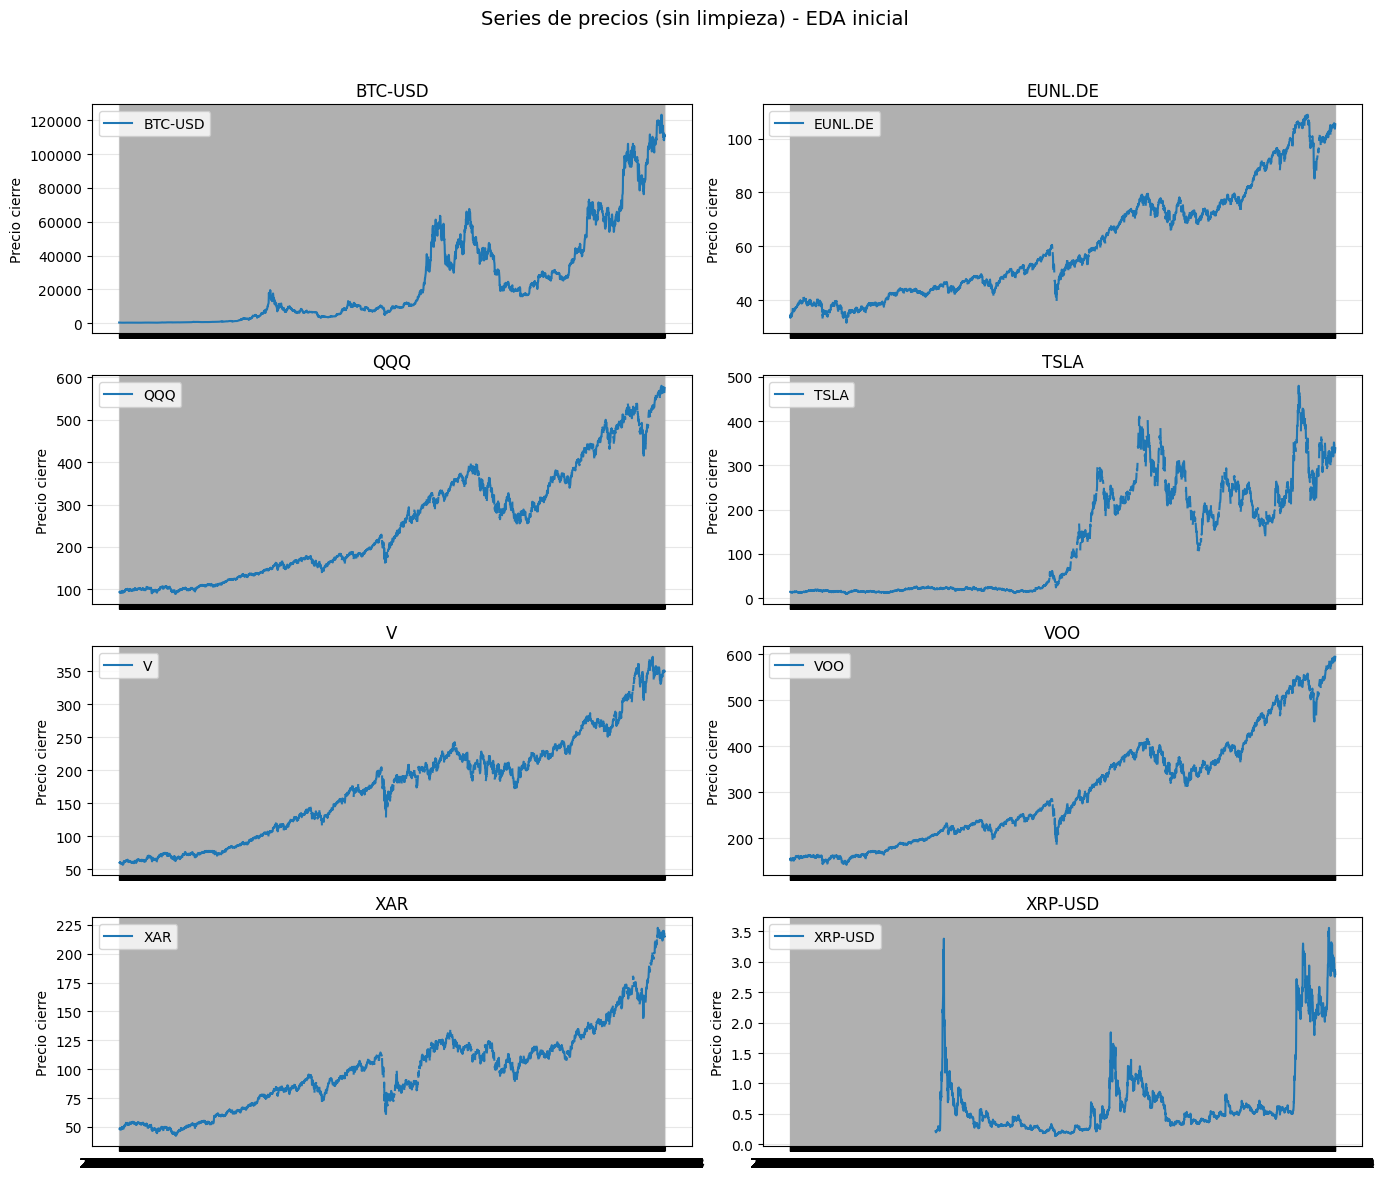

In [6]:
def plot_subplots(df: pd.DataFrame):
    """
    Genera subplots de series de precios (sin limpieza previa) para cada ticker
    contenido en un DataFrame en formato tidy.

    Propósito
    ---------
    - Visualizar de forma rápida la evolución de precios de cierre ajustados
      para todos los tickers disponibles en el dataset.
    - Explorar tendencias, volatilidad y posibles anomalías antes de la fase
      de limpieza y normalización.
    - Ofrecer una visión comparativa mediante subplots ordenados en cuadrícula.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame en formato tidy con las columnas mínimas:
        - 'date'   : fecha (datetime.date)
        - 'ticker' : símbolo del activo
        - 'close'  : precio de cierre ajustado

    Notas
    -----
    - El número de filas en la cuadrícula de subplots se calcula dinámicamente
      en función del número total de tickers.
    - Se crean siempre 2 columnas de gráficos para mejor legibilidad.
    - Si el número de tickers es impar, los ejes sobrantes se eliminan.
    - Cada subplot incluye título con el ticker, leyenda y grilla ligera.
    - El gráfico general incluye un título común a todos los subplots.

    Ejemplos
    --------
    >>> plot_subplots(market_df)
    # Devuelve una cuadrícula de gráficos con la serie de precios por ticker.
    """
    tickers = df["ticker"].unique()
    n = len(tickers)

    # Definimos tamaño de figura (filas dinámicas, 2 columnas)
    ncols = 2
    nrows = (n + 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(14, 3 * nrows), sharex=True)

    # Aplanamos ejes para iterar fácilmente
    axes = axes.flatten()

    # Iteramos sobre cada ticker y generamos la serie
    for i, tk in enumerate(tickers):
        subset = df[df["ticker"] == tk]
        axes[i].plot(subset["date"], subset["close"], label=tk, color="tab:blue")
        axes[i].set_title(f"{tk}", fontsize=12)
        axes[i].set_ylabel("Precio cierre")
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()

    # Quitamos ejes sobrantes si el número de tickers es impar
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Título general y ajuste de espaciado
    plt.suptitle("Series de precios (sin limpieza) - EDA inicial", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_subplots(market_df)